In [1]:
import cv2
import os

from keras.preprocessing.image import load_img, img_to_array
import numpy as np


from sklearn.model_selection import train_test_split


from keras.models import Sequential, Input

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D


import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Lambda
import tensorflow as tf


from keras import Model
import random

In [2]:
os.chdir("D:\\thesis_notebooks")
face_cascade = cv2.CascadeClassifier('D:\\BIT\\Thesis\\harrcascades\\haarcascade_frontalface_default.xml')
data = np.load("D:\\thesis_notebooks\\olivetti_faces\\olivetti_faces.npy")
target = np.load("D:\\thesis_notebooks\\olivetti_faces_target.npy")


In [3]:
data.shape


(400, 64, 64)

In [4]:
X_train, X_test, ytrain, ytest = train_test_split(data, target, test_size=0.3, stratify=target, random_state=0) 


In [5]:
X_train.shape

(280, 64, 64)

In [6]:
X_train = np.expand_dims(X_train, axis=-1)

In [7]:
X_test.shape

(120, 64, 64)

In [8]:
def siamese_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(9,9), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128, kernel_size=(7,7), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=256, kernel_size=(5,5),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=128,activation='sigmoid'))
    
    return model
    
    


In [9]:
# input_shape = X_train.shape[1:]

input_shape = (64,64,1)
siamese_network = siamese_model(input_shape)



X_test = np.expand_dims(X_test, axis=-1)

input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

output_top = siamese_network(input_top)
output_bottom = siamese_network(input_bottom)






In [10]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA-featsB), axis=1,keepdims=True)
    
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


distance = Lambda(euclidean_distance, output_shape=(1,)) ([output_top, output_bottom])

model = Model(inputs=[input_top, input_bottom], outputs=distance)


In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          1521280     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

In [12]:
X_train.shape

(280, 64, 64, 1)

In [13]:
def make_pairs(images, labels):

    pairImages = []
    pairLabels = []

    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    for idxA in range(len(images)):


        currentImage = images[idxA]
        label = labels[idxA]

        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return (np.array(pairImages), np.array(pairLabels))

In [14]:

(pairTrain, labelTrain) = make_pairs(X_train, ytrain)
(pairTest, labelTest) = make_pairs(X_test, ytest)

In [15]:
pairTest.shape

(240, 2, 64, 64, 1)

In [16]:
pairTrain.shape

(560, 2, 64, 64, 1)

In [17]:

def contrastive_loss(y, preds, margin=1):

    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [18]:
model.compile(loss=contrastive_loss, optimizer="adam", metrics=[accuracy])

In [19]:
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    validation_data=([pairTest[:,0], pairTest[:,1]], labelTest[:]),
                   batch_size=32, 
                   epochs=50)


Epoch 1/50
9/9 [==============================] - 14s 2s/step - loss: 0.3092 - accuracy: 0.5150 - val_loss: 0.4437 - val_accuracy: 0.5000
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 0.2425 - accuracy: 0.5388 - val_loss: 0.3772 - val_accuracy: 0.5000
Epoch 3/50
9/9 [==============================] - 17s 2s/step - loss: 0.2376 - accuracy: 0.5874 - val_loss: 0.3147 - val_accuracy: 0.5495
Epoch 4/50
9/9 [==============================] - 17s 2s/step - loss: 0.2216 - accuracy: 0.6325 - val_loss: 0.3191 - val_accuracy: 0.5495
Epoch 5/50
9/9 [==============================] - 16s 2s/step - loss: 0.2149 - accuracy: 0.6418 - val_loss: 0.2770 - val_accuracy: 0.6016
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 0.2121 - accuracy: 0.6655 - val_loss: 0.2647 - val_accuracy: 0.6328
Epoch 7/50
9/9 [==============================] - 15s 2s/step - loss: 0.2023 - accuracy: 0.6875 - val_loss: 0.2585 - val_accuracy: 0.6419
Epoch 8/50
9/9 [==================

Plotting results


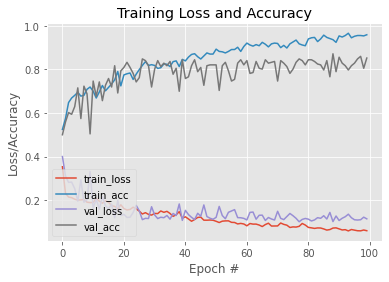

In [21]:
print("Plotting results")

def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)


plot_training(history, "D:\\thesis_notebooks\\aeioup.png")

In [21]:
model.save('D:\\thesis_notebooks\\\\today\\siamese_neural_network15.h5')
model.save_weights("D:\\thesis_notebooks\\today\\test_weight15.h5")

# After trained, the weights are saved to be used for demonstration

In [20]:
def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame

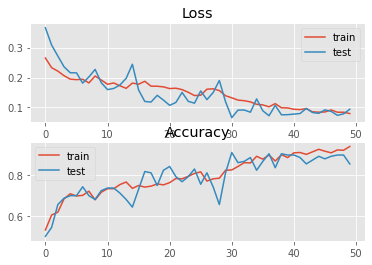

In [55]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix
from imutils.paths import list_images

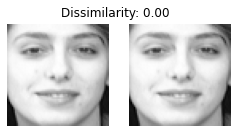

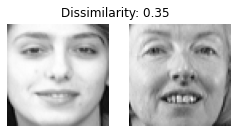

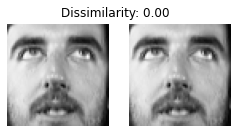

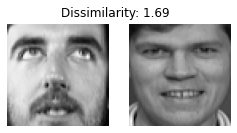

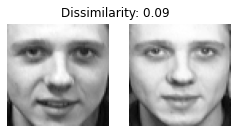

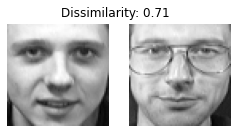

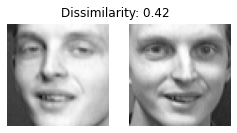

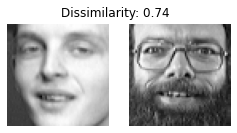

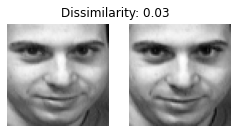

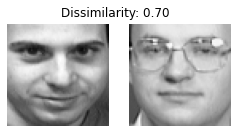

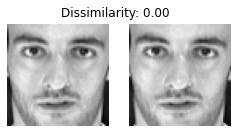

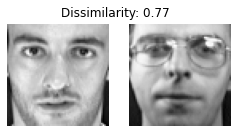

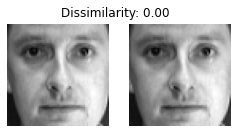

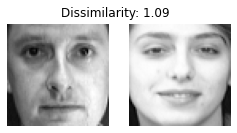

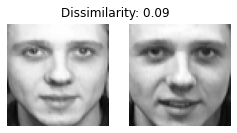

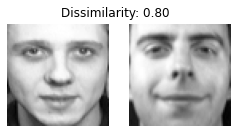

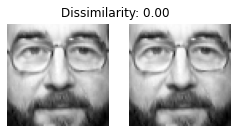

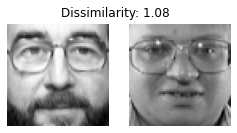

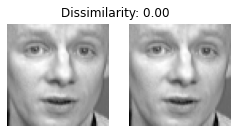

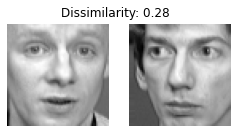

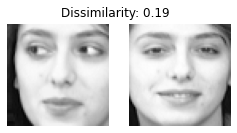

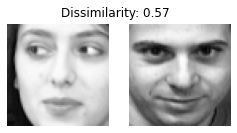

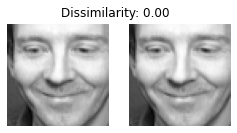

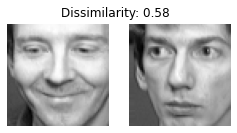

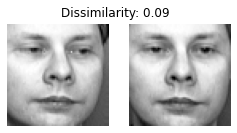

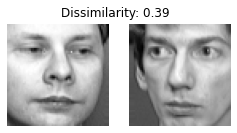

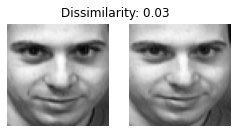

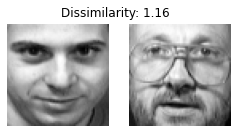

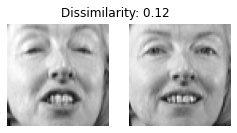

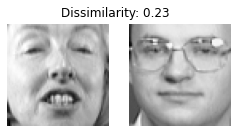

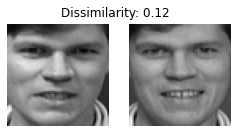

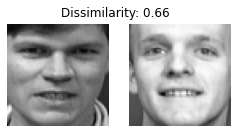

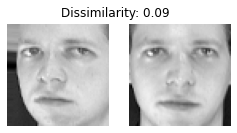

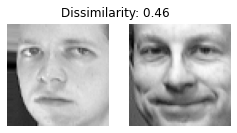

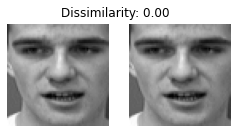

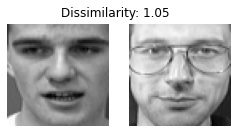

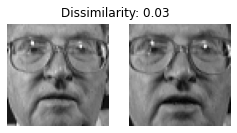

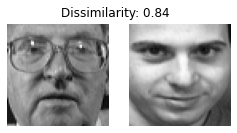

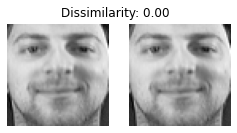

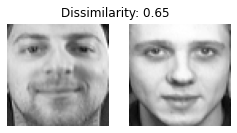

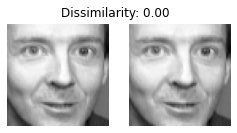

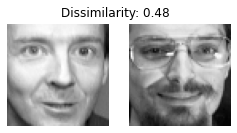

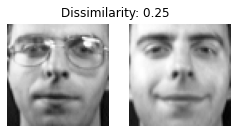

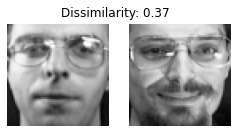

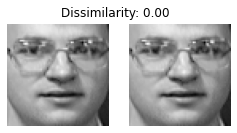

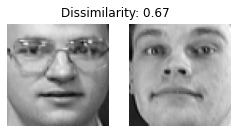

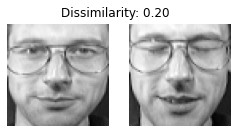

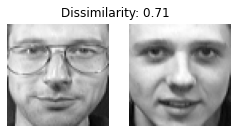

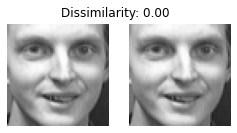

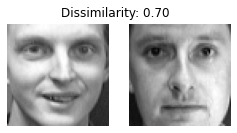

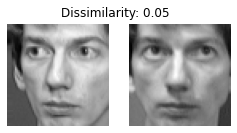

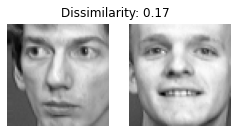

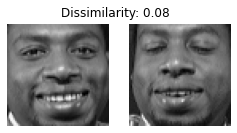

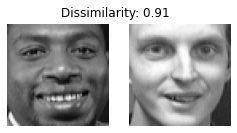

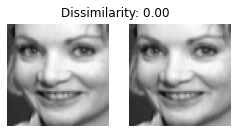

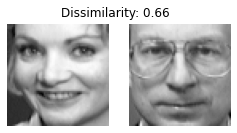

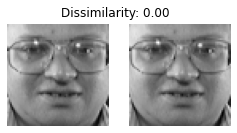

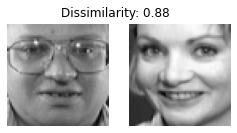

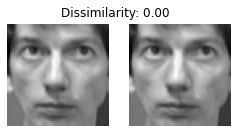

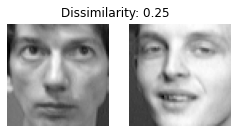

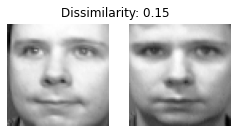

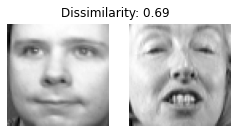

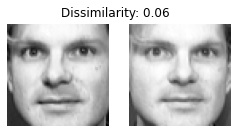

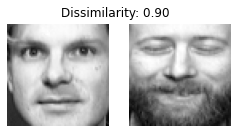

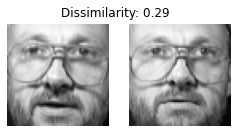

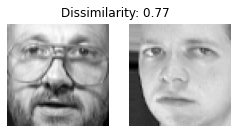

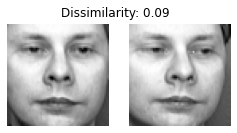

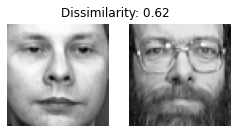

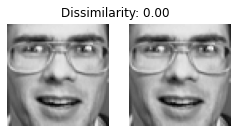

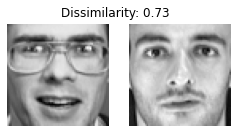

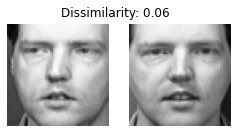

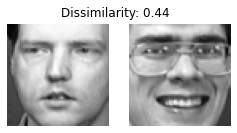

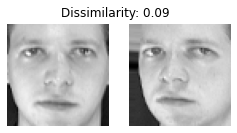

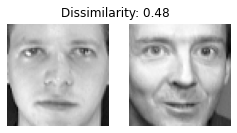

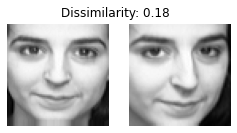

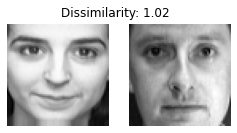

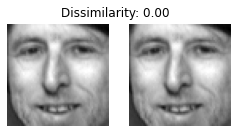

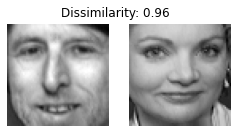

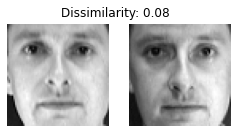

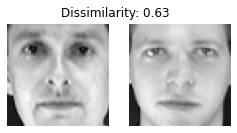

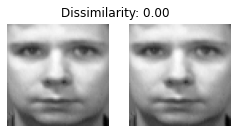

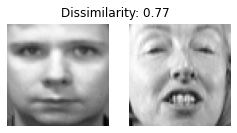

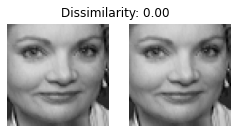

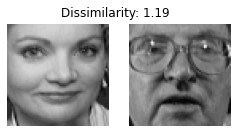

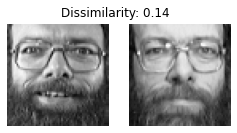

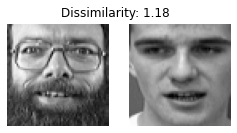

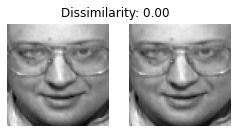

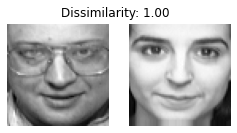

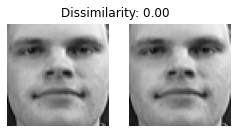

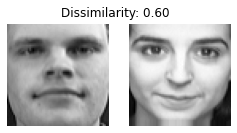

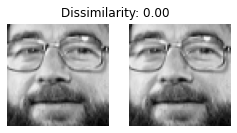

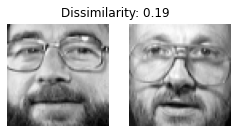

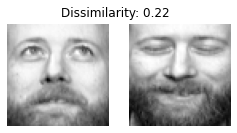

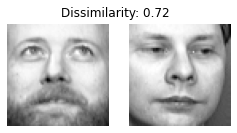

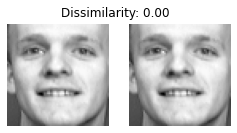

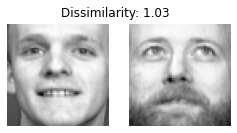

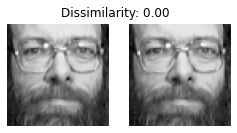

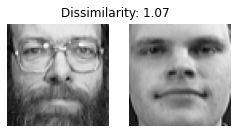

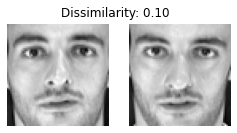

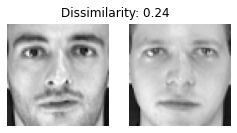

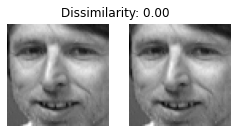

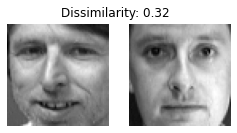

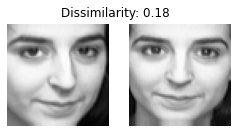

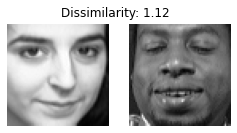

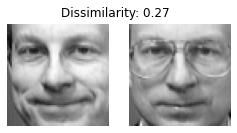

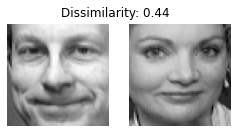

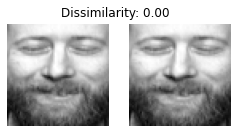

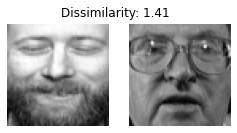

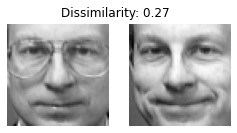

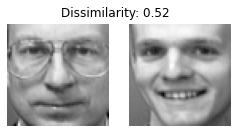

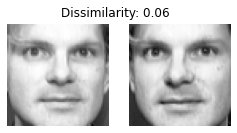

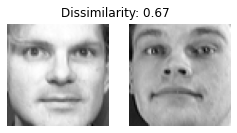

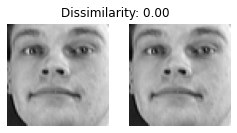

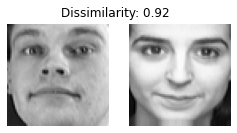

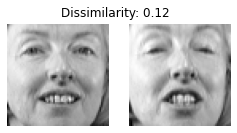

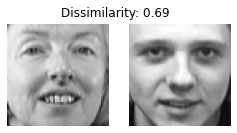

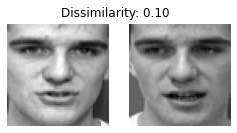

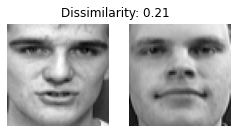

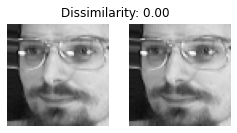

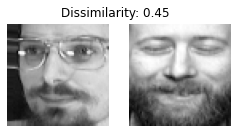

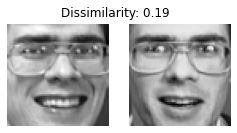

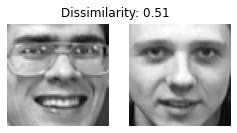

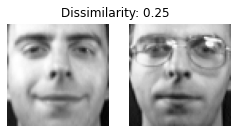

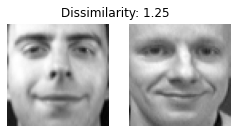

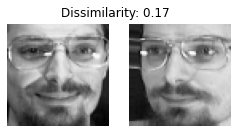

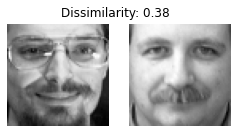

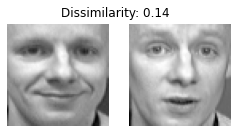

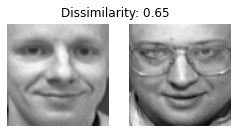

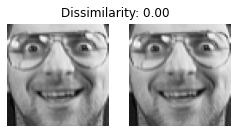

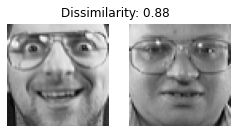

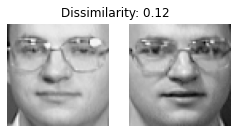

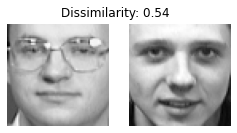

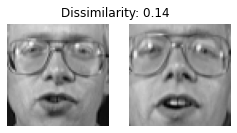

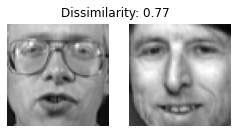

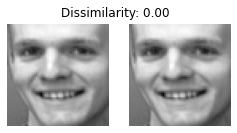

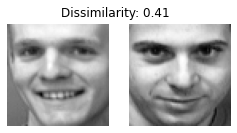

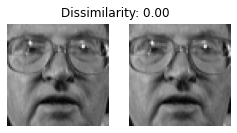

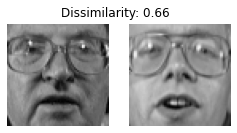

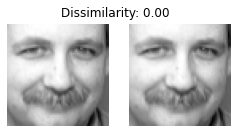

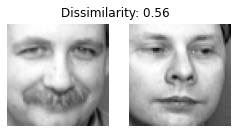

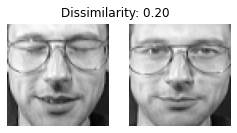

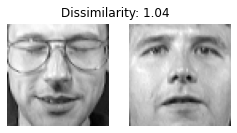

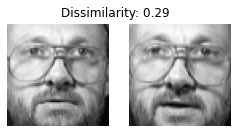

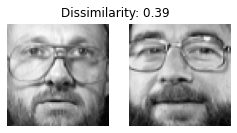

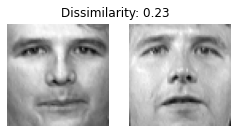

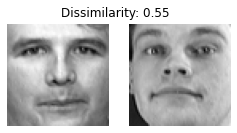

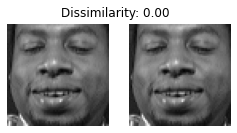

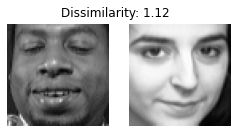

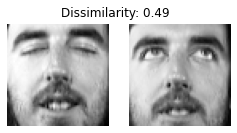

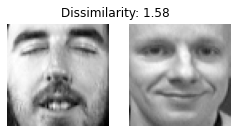

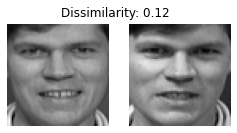

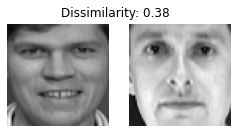

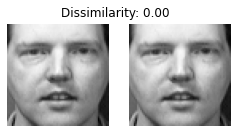

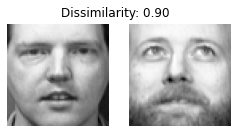

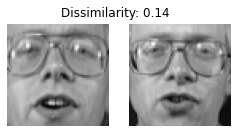

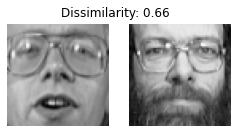

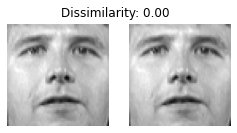

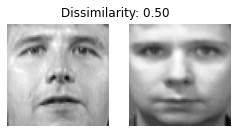

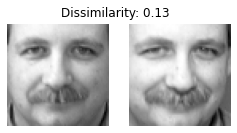

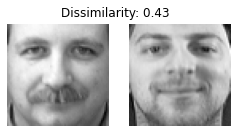

In [22]:
def detect_facess(img, draw_box=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5,
                                          minSize=(30,30),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    
    face_box, face_coords = None, []
    
    for (x,y,w,h) in faces:
        if draw_box:
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0),5)      
        face_box = img[y:y+h, x:x+w]

        face_coords = [x,y,w,h]
        
    return img, face_box, face_coords

In [22]:
import collections
import cv2


In [23]:
name = input("What is your name? ")

What is your name? Ahmed


In [25]:

import math

video_capture = cv2.VideoCapture(0)
counter = 15

while True:
    _, frame = video_capture.read()
    frame, face_box, face_coords = detect_facess(frame)
    text = "Image will be taken in {}..".format(math.ceil(counter))
    if face_box is not None:
        frame = write_on_frame(frame, text, face_coords[0],
                              face_coords[1]-10)
    
    
    cv2.imshow('Video', frame)
    cv2.waitKey(1)
    counter -= 0.1
    if counter <= 0:
        cv2.imwrite('D:\\thesis_notebooks\\testimage120.png', face_box)
        break

video_capture.release()
cv2.destroyAllWindows()
# print('Onboarding Image Captured')

In [28]:
true_img = cv2.imread('D:\\thesis_notebooks\\testimage120.png', 0)
true_img = true_img.astype('float32')/255
true_img = cv2.resize(true_img, (64, 64))
true_img = true_img.reshape(1, true_img.shape[0], true_img.shape[1], 1)

In [29]:
import collections
import cv2

In [32]:
video_capture = cv2.VideoCapture(0)
preds = collections.deque(maxlen=15)
while True:
    _, frame = video_capture.read()
    frame, face_img, face_coords = detect_facess(frame, draw_box=False)
    
    if face_img is not None:
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        face_img = face_img.astype('float32')/255

        face_img = cv2.resize(face_img, (64,64))
        face_img = face_img.reshape(1, face_img.shape[0], face_img.shape[1], 1)
        
        preds.append(1-model.predict([true_img, face_img])[0][0])
        x, y, w, h = face_coords
        
        if len(preds) == 15 and sum(preds)/15 >= 0.3:
            text = '{}'.format(name)
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 5)
        elif len(preds) < 15:
            text = 'Identifying...'
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,165,255), 5)
        else:
            text = "Unknown!"
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 5)
        frame = write_on_frame(frame, text, face_coords[0], face_coords[1]-10)
    else:
        preds = collections.deque(maxlen=15)
    
    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()




In [22]:
model.save('D:\\thesis_notebooks\\siamese_neural_network1.h5')
model.save_weights("D:\\thesis_notebooks\\test_weight1.h5")